This script plots a 2d map of the relative difference between ERA5 and ESA soil moisture from 1980-2019

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [3]:
scratch_path = '/glade/u/home/zcleveland/scratch/'
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'

In [58]:
# define a function to plot a time series of ERA5 vs ESA soil moisture
def era5_vs_esa_sm_ts(overwrite_flag=False):
    # create out filename and path -- check existence
    out_fn = 'ERA5_vs_ESA_sm_cp.png'
    out_fp = os.path.join(plot_out_path, 'time_series', out_fn)

    if overwrite_flag:
        pass
    elif os.path.exists(out_fp):
        print(f'{out_fn} already exists.  Set overwrite_flag=True to overwrite.')
        print('Skipping . . .\n')
        return
    else:
        print(f'Starting plot for {out_fn}')

    # get file path for datasets
    diff_files = f'{scratch_path}ERA5/regrid-to-esa/*/*diff_ERA5_ESA*.nc'

    # open datasets
    diff_ds = xr.open_mfdataset(diff_files)

    # compute average monthly values over Colorado Plateau (line)
    cp_lat = slice(39,35)
    cp_lon = slice(-111, -107)
    diff_cp_ds = diff_ds.sel(latitude=cp_lat, longitude=cp_lon)
    diff_cp_monthly = diff_cp_ds['__xarray_dataarray_variable__'].resample(time='1M').mean(dim=['time', 'latitude', 'longitude'])

    # compute average over all dims for CP
    diff_cp_avg = diff_cp_ds['__xarray_dataarray_variable__'].mean(dim=['time', 'latitude', 'longitude'])

    # create dara array with same dimensions as diff_cp_monthly for plotting
    diff_cp_avg_da = xr.DataArray([diff_cp_avg.values.item()]*len(diff_cp_monthly.time), 
                              dims=['time'], 
                              coords={'time': diff_cp_monthly.time})

    # plot line graph
    # set up figure 
    plt.figure(figsize=(12,6))
    diff_cp_monthly.plot(label='Monthly Diff', color='purple')
    diff_cp_avg_da.plot(label='Average', linestyle='--', color='green')
    # plt.plot(diff_cp_line, label='Average', color='green')
    plt.title('Relative Difference in ERA5 and ESA\nSoil Moisture Content')
    plt.xlabel('Time (months)')
    plt.ylabel('Soil Moisture Content (m$^3$ m$^{-3}$)')
    plt.legend(loc='upper left')
    plt.tight_layout()
    # plt.savefig(out_fp, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

/glade/u/home/zcleveland/.conda/envs/mland_xr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


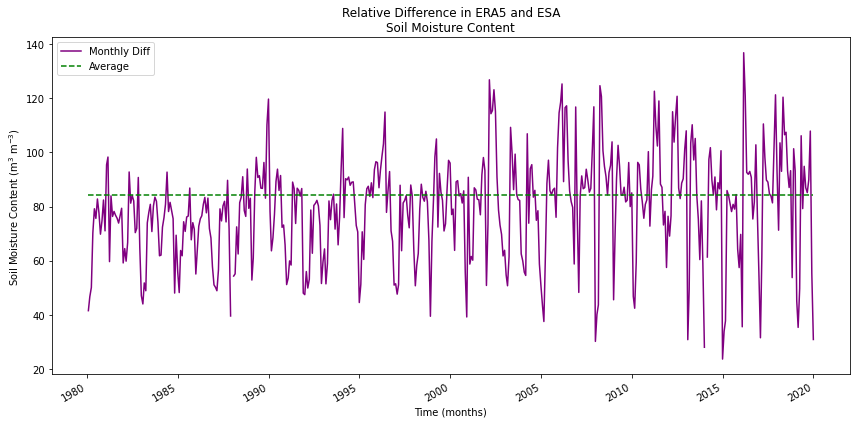

In [59]:
if __name__ == '__main__':
    era5_vs_esa_sm_ts(overwrite_flag=False)

In [11]:
# define function to plot the 2d spatial map of the relative difference in ERA5 and ESA soil moisture content
def era5_vs_esa_sm_map(overwrite_flag=False):
    # create out filename and path -- check existence
    out_fn = 'ERA5_vs_ESA_sm_cp.png'
    out_fp = os.path.join(plot_out_path, '2d_spatial', out_fn)

    if overwrite_flag:
        pass
    elif os.path.exists(out_fp):
        print(f'{out_fn} already exists.  Set overwrite_flag=True to overwrite.')
        print('Skipping . . .\n')
        return
    else:
        print(f'Starting plot for {out_fn}')

    # get file path for datasets
    diff_files = f'{scratch_path}ERA5/regrid-to-esa/*/*diff_ERA5_ESA*.nc'

    # open datasets
    diff_ds = xr.open_mfdataset(diff_files)

    # compute average difference of relative difference over all 40 years
    diff_cp_spatial = diff_ds['__xarray_dataarray_variable__'].mean(dim='time')

    # plot map
    # set up figure
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    vmax = diff_cp_spatial.max()
    vmin = diff_cp_spatial.min()

    levels = np.linspace(0, 100, 50) 
    # plot the data using contourf
    cf = plt.contourf(diff_cp_spatial.longitude, diff_cp_spatial.latitude,
                      diff_cp_spatial, levels=levels,
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)

    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # plot features
    plt.title('Average Relative Difference in ERA5 and ESA\nSoil Moisture Content (1980-2019)')
    plt.colorbar(cf, ax=ax, label='Soil Moisture Content (m$^3$ m$^{-3}$)')
    plt.tight_layout()
    # plt.savefig(out_fp, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

Starting plot for ERA5_vs_ESA_sm_cp.png


/glade/u/home/zcleveland/.conda/envs/mland_xr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


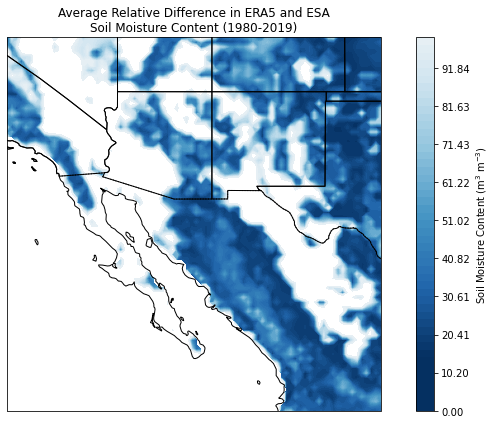

In [12]:
if __name__ == '__main__':
    era5_vs_esa_sm_map(overwrite_flag=False)